1. Здійсніть імпорт необхідних бібліотек.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import time
import os
import opendatasets as od
from PIL import Image
from tempfile import TemporaryDirectory
import torch.nn.functional as F
import splitfolders
from pylab import *
import zipfile


from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

plt.ion() # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

2. Підготовка даних:

Завантажте набір даних Intel Image Classification з платформи Kaggle.
Розділіть дані на тренувальний, валідаційний та тестовий набори. Дані вже розділені на навчальні та тестові. Вам слід відділити частину навчальних даних для отримання валідаційного набору даних.


In [5]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/puneet6060/intel-image-classification'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


100%|██████████| 346M/346M [02:25<00:00, 2.49MB/s] 


In [10]:
input_folder = 'intel-image-classification/seg_train/seg_train'

splitfolders.ratio(input_folder,
                   output="intel-image-classification/train_data",
                   seed=42,
                   ratio=(.8, .2),
                   group_prefix=None)

Copying files: 14034 files [00:07, 1866.91 files/s]


2. Попередня обробка зображень:

Застосуйте необхідні перетворення (наприклад, зміна розміру, нормалізація) за допомогою torchvision.transforms.

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()]),
    'val': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()])}

Використайте torchvision.datasets і torch.utils.data.DataLoader для завантаження та підготовки даних.

In [12]:
data_dir = 'intel-image-classification/train_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets['test'] = datasets.ImageFolder("intel-image-classification/seg_test/seg_test", data_transforms['val'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=3000,
                                             shuffle=True, num_workers=4)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 11224, 'val': 2810, 'test': 3000}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


3. Створення моделі: Варіант A: Проста згорткова нейронна мережа

Створіть власну архітектуру CNN за допомогою torch.nn.
Визначте шари згортки (Conv2d), активації (ReLU), пулінгу (MaxPool2d) та повнозв'язні шари (Linear).

In [13]:
class BaselineModel(nn.Module):

    def __init__(self, ):
        super().__init__()
        self.num_channels = 32

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)

    def forward(self, s):
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.conv1(s)                                   # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.conv2(s)                                   # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.conv3(s)                                   # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.relu(self.fc1(s))                             # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)

In [14]:
cuda = torch.cuda.is_available()

# Set the random seed for reproducible experiments
torch.manual_seed(42)
if cuda:
  torch.cuda.manual_seed(42)

# Specify a computing device
device = 'cuda' if cuda else None

5. Визначення функції втрат та оптимізатора:

Виберіть відповідну функцію втрат (наприклад, CrossEntropyLoss). Обґрунтуйте вибір функції втрат.
Виберіть оптимізатор (наприклад, Adam або SGD).

In [15]:
# Define the model and optimizer
model = BaselineModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define loss function
criterion = nn.CrossEntropyLoss().to(device)

6. Навчання моделі:

Напишіть цикл навчання з використанням PyTorch.
Обчислюйте втрати, виконуйте зворотне поширення та оновлюйте ваги.
Зберігайте модель з найкращими показниками на валідаційному наборі.

In [16]:
# Train the model

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 7

for epoch in tqdm(range(num_epochs)):

    # Train step

    model.train()

    train_epoch_loss = []
    train_epoch_acc = []

    for i, (train_batch, labels_batch) in tqdm(enumerate(dataloaders["train"])):
        if cuda:
            train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

        # compute model output and loss
        output_batch = model(train_batch)

        loss = criterion(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                            labels_batch.cpu().detach().numpy())

        train_epoch_loss.append(batch_loss)
        train_epoch_acc.append(batch_acc)


    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))

    # Eval step

    model.eval()

    test_epoch_loss = []
    test_epoch_acc = []

    with torch.no_grad():

        for i, (test_batch, labels_batch) in enumerate(dataloaders["val"]):
            if cuda:
                test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

            # compute model output and loss
            output_batch = model(test_batch)

            loss = criterion(output_batch, labels_batch)

            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                                labels_batch.cpu().detach().numpy())

            test_epoch_loss.append(batch_loss)
            test_epoch_acc.append(batch_acc)
    print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/7], Loss: 1.0764, Acc: 0.6024711067403439
Test epoch [1/7], Loss: 0.9507, Acc: 0.6746968877082513


0it [00:00, ?it/s]

Train epoch [2/7], Loss: 0.7885, Acc: 0.7234355446178808
Test epoch [2/7], Loss: 0.6742, Acc: 0.756780551098733


0it [00:00, ?it/s]

Train epoch [3/7], Loss: 0.6467, Acc: 0.7753794240475153
Test epoch [3/7], Loss: 0.6007, Acc: 0.77273643444098


0it [00:00, ?it/s]

Train epoch [4/7], Loss: 0.5753, Acc: 0.7963138346827805
Test epoch [4/7], Loss: 0.5475, Acc: 0.80488721085312


0it [00:00, ?it/s]

Train epoch [5/7], Loss: 0.5130, Acc: 0.8273377345457117
Test epoch [5/7], Loss: 0.5647, Acc: 0.7987038214310942


0it [00:00, ?it/s]

Train epoch [6/7], Loss: 0.4635, Acc: 0.8392616184069175
Test epoch [6/7], Loss: 0.5293, Acc: 0.8051812350107805


0it [00:00, ?it/s]

Train epoch [7/7], Loss: 0.4173, Acc: 0.855620513811397
Test epoch [7/7], Loss: 0.4932, Acc: 0.8308878043253042


7. Оцінка моделі:

Оцініть продуктивність моделі на тестовому наборі даних.
Обчисліть метрики, наприклад F1-score тощо. Обґрунтуйте вибір метрики.

Ми для оцінки якості моделі візьмемо такі метрики:
- balanced_accuracy_score - бо вона підходить для багатокласової класифікації (взагалі для незбалансованих класів, але й для більш менш збалансованих теж підходить)
- f1_score - бо вона поєднує в собі оцінку і точності і повноти навченої моделі

In [17]:
for i, (test_data, test_labels) in enumerate(dataloaders["test"]):
  pass

if cuda:
    test_data, test_labels = test_data.cuda(non_blocking=True), test_labels.cuda(non_blocking=True)
test_output = model(test_data)


test_acc = balanced_accuracy_score(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy())
f1_test = f1_score(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy(), average=None)
average_f1_test = f1_score(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy(), average='weighted')

print(f'Balanced accuracy score = {test_acc}')
print(f'F1 scores for each class = {f1_test}')
print(f'Average F1 score = {average_f1_test}')

Balanced accuracy score = 0.8172639061597917
F1 scores for each class = [0.77108434 0.92798354 0.79282511 0.76502732 0.8016444  0.83003953]
Average F1 score = 0.8148039566823596


З більшою кількістю епох результат виходив трішки кращий:

Balanced accuracy score = 0.8218623371817392

F1 scores for each class = [0.77818182 0.92244898 0.79828326 0.7654321  0.8173258  0.82730924]

Average F1 score = 0.8200243825321353


Але навчання займало більше часу і криві навчання виглядали так ніби вже після 7 епохи відбувалось перенавчання (по крива на тренувальній вибірці покращувала показники, а на валідаційній була на місці)

8. Аналіз результатів:

Візуалізуйте результати (наприклад, матрицю помилок, криві навчання).
Проаналізуйте помилки класифікації.

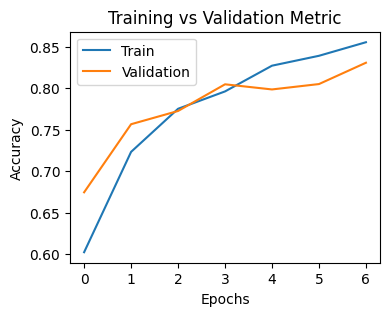

In [18]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()

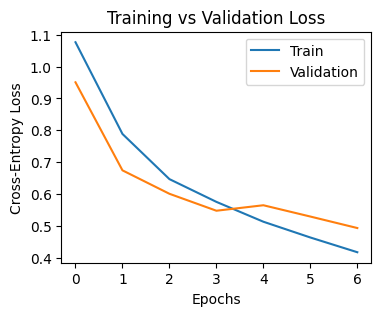

In [19]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()

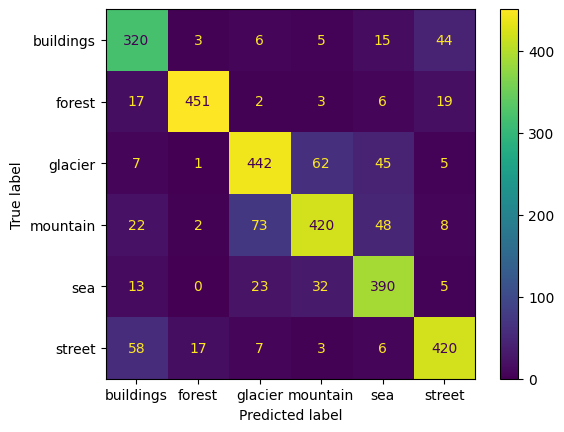

In [20]:
conf_matrix = confusion_matrix(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
disp.plot()

З матриці бачимо, що модель помиляється в класифікації схожих категорій: 
- вулиці і будівлі, 
- море, гори і льодовики
що, в принципі, очікувано.

Для покращення можна поекспериментувати з архітектурою та гіперпараметрами або скористатися уже готовою навченою моделлю, що я й зробила далі.

**Варіант B: Transfer Learning**

Застосуйте необхідні перетворення (наприклад, зміна розміру, нормалізація) за допомогою torchvision.transforms.

In [21]:
data_transforms_transfer = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Використайте torchvision.datasets і torch.utils.data.DataLoader для завантаження та підготовки даних.

In [22]:
data_dir = 'intel-image-classification/train_data'
image_datasets_transfer = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_transfer[x])
                  for x in ['train', 'val']}
image_datasets_transfer['test'] = datasets.ImageFolder("intel-image-classification/seg_test/seg_test", data_transforms_transfer['val'])
dataloaders_transfer = {x: torch.utils.data.DataLoader(image_datasets_transfer[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataloaders_transfer['test'] = torch.utils.data.DataLoader(image_datasets_transfer['test'], batch_size=3000,
                                             shuffle=True, num_workers=4)
dataset_sizes = {x: len(image_datasets_transfer[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets_transfer['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 11224, 'val': 2810, 'test': 3000}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Імпортуйте попередньо навчену модель (наприклад, ResNet18) з torchvision.models. Модифікуйте останній шар відповідно до кількості класів у вашому завданні.

In [23]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [24]:
for param in model_conv.parameters():
    param.requires_grad = False

In [25]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

Виберіть відповідну функцію втрат (наприклад, CrossEntropyLoss). Обґрунтуйте вибір функції втрат.
Виберіть оптимізатор (наприклад, Adam або SGD).

In [26]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-03)

Напишіть цикл навчання з використанням PyTorch.
Обчислюйте втрати, виконуйте зворотне поширення та оновлюйте ваги.
Зберігайте модель з найкращими показниками на валідаційному наборі.

In [27]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

				# save model
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders_transfer[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [28]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.6570 Acc: 0.7676
val Loss: 0.3125 Acc: 0.8904

Epoch 2/5
----------
train Loss: 0.4450 Acc: 0.8367
val Loss: 0.2995 Acc: 0.8929

Epoch 3/5
----------
train Loss: 0.4268 Acc: 0.8415
val Loss: 0.2843 Acc: 0.9011

Epoch 4/5
----------
train Loss: 0.4170 Acc: 0.8449
val Loss: 0.2732 Acc: 0.8993

Epoch 5/5
----------
train Loss: 0.4118 Acc: 0.8486
val Loss: 0.2595 Acc: 0.9039

Training complete in 2m 41s
Best val Acc: 0.903915


Оцініть продуктивність моделі на тестовому наборі даних.
Обчисліть метрики, наприклад F1-score тощо. Обґрунтуйте вибір метрики.

In [29]:
cuda = torch.cuda.is_available()

# Set the random seed for reproducible experiments
torch.manual_seed(42)
if cuda:
  torch.cuda.manual_seed(42)

# Specify a computing device
device = 'cuda' if cuda else None

In [30]:
for i, (test_data, test_labels) in enumerate(dataloaders_transfer["test"]):
  pass

if cuda:
    test_data, test_labels = test_data.cuda(non_blocking=True), test_labels.cuda(non_blocking=True)
test_output = model_conv(test_data)


test_acc = balanced_accuracy_score(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy())
f1_test = f1_score(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy(), average=None)
average_f1_test = f1_score(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy(), average='weighted')

print(f'Balanced accuracy score = {test_acc}')
print(f'F1 scores for each class = {f1_test}')
print(f'Average F1 score = {average_f1_test}')

Balanced accuracy score = 0.9082427729360684
F1 scores for each class = [0.89670829 0.99159664 0.85587975 0.83585096 0.95402299 0.91291291]
Average F1 score = 0.9073591078035592


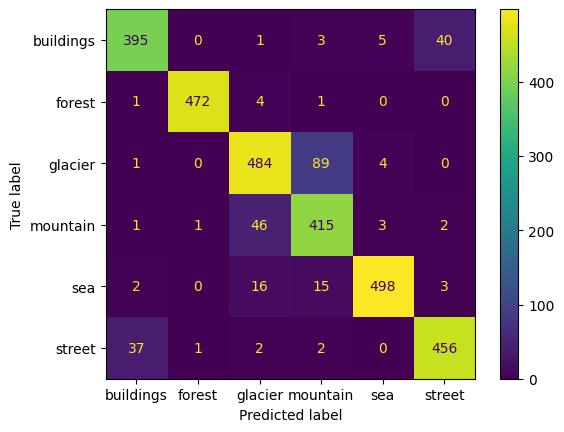

In [31]:
conf_matrix = confusion_matrix(np.argmax(test_output.cpu().detach().numpy(), axis=1),
                                                test_labels.cpu().detach().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
disp.plot()

За метриками якості модель з використанням трансферного навчання краща за написану з нуля.
Та й на confusion matrix бачимо, що ця модель краще розрізняє будинки і вулиці, не плутаючи з лісом, та гарно класифікує море, менш плутаючи з горами та льодовиками.

In [32]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_transfer['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


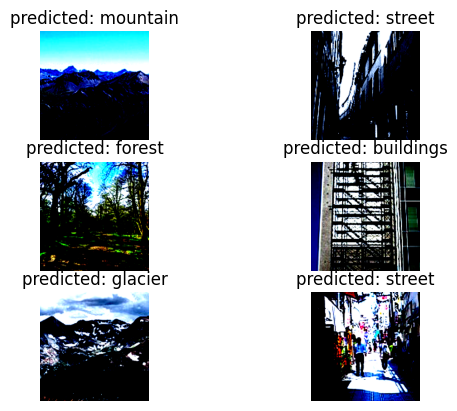

In [33]:
visualize_model(model_conv)